# Project Milestone 2 Pipeline

Our pipeline has the following 4 major parts: 
##### 1. Data cleaning and data quality analysis
##### 2. Movie releases and genre over time 
##### 3. Historical events scraping and plot analysis 
##### 4. Historical events and genre analysis 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from enum import Enum
import json

In [11]:
class Data(Enum):
    MOVIES = "movie.metadata.tsv"
    PLOTS = "plot_summaries.txt"
    NAME_CLUSTERS = "name.clusters.txt"
    EVENTS = "AnnotatedListOfEvents.json"

def load_data(type : Data, columns, index_col = ""):
    """
    Loads data of type using the Data Enum, with columns, and index_col as the index if provided. The data must be in a folder named MovieSummaries.

    returns: DataFrame
    """
    return pd.read_csv(
        f'./rawdata/MovieSummaries/{type.value}', 
        sep="\t", 
        names=columns,
        index_col=index_col if index_col != "" else columns[0]
    )

def load_events(): 
    """
    Loads the events data from json

    returns: a list of event objects (name, date, link)
    """
    f = open('AnnotatedListOfEvents.json')
    event_data = json.load(f)['events']
    return event_data


orig_movie_df = load_data(
    Data.MOVIES, 
    ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"],
)
plot_df = load_data(
    Data.PLOTS, 
    ["wiki_id", "plot"]
)
name_df = load_data(
    Data.NAME_CLUSTERS, 
    ["character_name", "freebase_id"],
    index_col="freebase_id"
)
event_data = load_events()


## Data Cleaning
Here we match the movies metadata with the plot summaries, and clean out unnecessary punctuations, parse strings into separate and processable values, use appropriate datatypes etc. 

In [12]:
def parse_multi_values(x): 
    """
    Parses the multi value structure of the dataset format into a sorted array of items
    Returns null values for empty lists as NaN (so all missing values we use are NaN)
    
    returns: array of strings extracted from x
    """
    if not x: 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            combo[1] = combo[1].strip()
            result.append(combo[1])
    if not result:
        return []
    return sorted(result)

def parse_language(languages):
    """
    Parses the language column specifically by removing "Langauge" from each entry

    returns: list of strings of the languages
    """
    if not languages or type(languages) != list:
        return []
    return list(map(lambda l : l.replace("Language", "").strip(), languages))

def parse_date(x):
    """
    Parses the date format into an int representing only the year. Values with missing entries are given NaN.

    returns: string representing the year 
    """
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

def remove_outliers(df : pd.DataFrame):
    """
    Since we are interested in how movies change over time, we are removing all the values without release_date 
    and we also remove an outlier from 1010 and year 2015 since it's not a full year (it ends in March)

    returns: same dateframe df but with outliers removed
    """
    df = df[df['release_date'] != 'nan']
    df = df[df['release_date'] != '1010']
    df = df[df['release_date'] != '2013']
    df = df[df['release_date'] != '2014']
    df = df[df['release_date'] != '2015']
    df = df[df['release_date'] != '2016']
    return df

def data_clean_movies(df):
    # Add plot summaries to the movie dataframe
    df = df.join(plot_df)

    # Parse multi value attributes into arrays
    for attribute in ["languages", "countries", "genres"]:
        df[attribute] = df[attribute].apply(parse_multi_values)

    # Remove "Language" from language column
    df["languages"] = df["languages"].apply(parse_language)

    # Parse release-date to all use the year as an int (don't need increased granularity right now)
    df["release_date"] = df["release_date"].apply(parse_date)

    # Remove certain outliers 
    df = remove_outliers(df)

    # Replace missing numeric values with zero and convert to int rather than float
    for col in ["runtime", "revenue", "release_date"]:
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype(int)
    
    return df

# Create df that is cleaned
movie_df = data_clean_movies(orig_movie_df)

# Display the head to get a sense for the data
display(movie_df.head(10))

,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot
wiki_id,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001,14010832,98,[English],[United States of America],"[Action, Adventure, Horror, Science Fiction, S...","Set in the second half of the 22nd century, th..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,0,95,[English],[United States of America],"[Biographical film, Crime Drama, Drama, Mystery]",NaN
28463795,/m/0crgdbh,Brun bitter,1988,0,83,[Norwegian],[Norway],"[Crime Fiction, Drama]",NaN
9363483,/m/0285_cd,White Of The Eye,1987,0,110,[English],[United Kingdom],"[Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...
261236,/m/01mrr1,A Woman in Flames,1983,0,106,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
13696889,/m/03cfc81,The Gangsters,1913,0,35,"[English, Silent film]",[United States of America],"[Blackandwhite, Comedy, Indie, Short Film, Sil...",NaN
18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,0,86,[English],[South Africa],"[Adventure, Family Film, Fantasy, World cinema]","Every hundred years, the evil Morgana returns..."
10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000,106,[English],[United States of America],"[Blackandwhite, Comedy, Musical]",NaN
9997961,/m/06_y2j7,Contigo y aquí,1974,0,0,[Spanish],[Argentina],"[Comedy, Drama, Musical]",NaN


### Analyzing missing values
Here we have a rough idea of the quality of the data, where we realized the genre data is relatively complete among the dataset. 

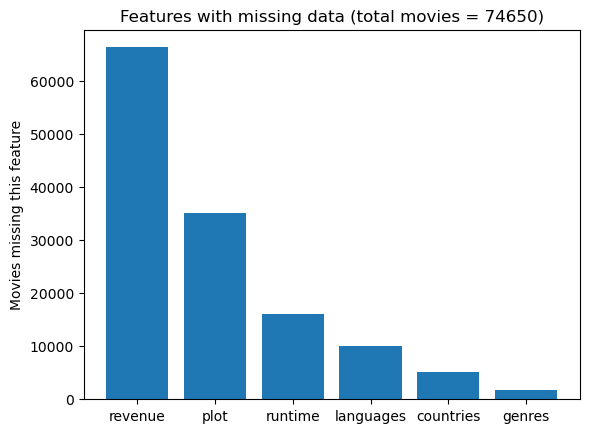

Rows without any missing data is 39511


In [13]:
def analyze_missing_values(df : pd.DataFrame): 
    """
    Checks to what extent we have missing data. For each column, count the number of missing data and plot a bar graph.
    """

    # Dictionary from col to missing values count 
    missing = {}
    for col in df.columns:
        # Missing are na or empty falsy values such as empty lists
        num_missing = df[col].isna().sum() + (df[col].astype(bool) == False).sum()
        if num_missing > 0:
            missing[col] = num_missing
    missing = sorted(missing.items(), key=lambda x: x[1], reverse=True)
    plt.bar(
        list(map(lambda x : x[0], missing)), 
        list(map(lambda x : x[1], missing)),
    )
    plt.title("Features with missing data (total movies = " + str(df.shape[0]) + ")")
    plt.ylabel("Movies missing this feature")
    plt.show()

    # Count how many rows are without any missing values
    non_missing = (df.notnull().all(axis="columns") == True).sum()
    print("Rows without any missing data is", non_missing)

analyze_missing_values(movie_df)

## Data Analysis Part 1: movie releases and genre over time 
### How many movies are released per year? 
It's obvious to see from the graph beneath the the number of movies has increased significantly since 2005, with over 1500 movies released per year

number_by_year is  release_date
1888       1
1889       1
1890       2
1891       3
1892       3
        ... 
2008    2465
2009    2247
2010    2022
2011    1824
2012    1194
Name: name, Length: 125, dtype: int64
years is  125


Text(0.5, 1.0, 'The number of movies released by year')

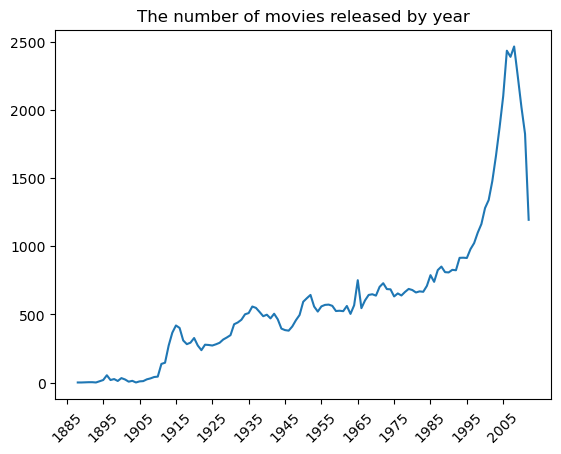

In [14]:
number_by_year = movie_df.groupby('release_date')['name'].count()
print("number_by_year is ", number_by_year)
years = list(range(1888, 2013, 1))
print("years is ", len(years))

fig, ax = plt.subplots()
ax.plot(years, number_by_year.values)
plt.xticks(np.arange(1885, 2015, 10), rotation = 45) 
plt.title("The number of movies released by year")

In [15]:
print(number_by_year[-15:-1])

release_date
1998    1100
1999    1163
2000    1280
2001    1339
2002    1478
2003    1662
2004    1872
2005    2102
2006    2434
2007    2389
2008    2465
2009    2247
2010    2022
2011    1824
Name: name, dtype: int64


### How does the frequency of genres change over time? 
* First, we cleaned up the genre cateogries into broader, more generalizable categories. 
  * a few examples of the cleaning efforts "biographical film" is shortened to "biographical", "actionadventure" is split into "action" and "adventure", and "romance" is combined with "romantic" 
* Then, we observe the number of films of certain genre released over time

,release_date,genre_divided
wiki_id,,
975900,2001,"[western, thriller, action, fiction, adventure..."
3196793,2000,"[crime, mystery, biographical, drama]"
28463795,1988,"[crime, fiction, drama]"
9363483,1987,"[psychological, erotic, thriller]"
261236,1983,[drama]
13696889,1913,"[comedy, short, silent, blackandwhite, indie]"
18998739,2002,"[adventure, family, world, fantasy]"
10408933,1938,"[comedy, blackandwhite, musical]"
9997961,1974,"[comedy, musical, drama]"


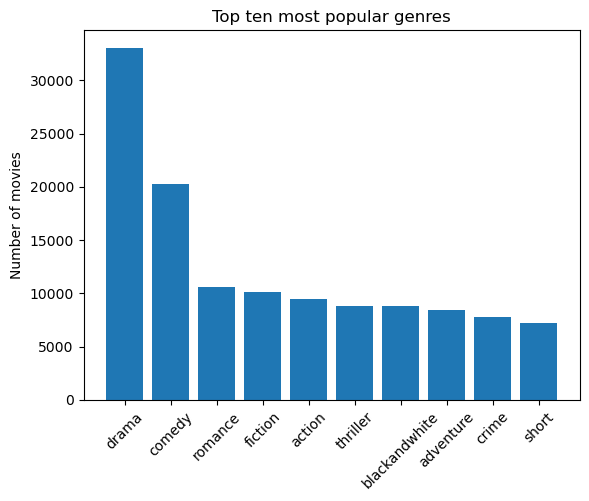

In [16]:
def combine_lists(elements):
    """
    Separate a word like "pyschological thriller" to "psychological" and "thriller"

    returns: list
    """
    result = []
    for x in elements: 
        result += x
    return result

def to_1D(series):
    """
    Maps a list of items in a series.

    returns: pd.Series 
    """
    return pd.Series([x for _list in series for x in _list])
    
movie_df['genre_divided'] = movie_df['genres'].apply(lambda x: [word.lower().split(" ") for word in x]).apply(combine_lists)

def remove_certain_genre(l):
    """
    Removes certain meaningless keywords from genre like "film" and "movies"
    Removes repeated words by changing to set; 
    if a film is ["romatic comedy", "dark comedy"], it would become ["romatic", "dark", "comedy"]

    returns: filtered list
    """
    no_meaning_words = {"film", "movies", "of", "movie", "cinema"}
    l = set(l)
    for word in no_meaning_words:
        if word in l: 
            l.remove(word)
    return list(l)

def swap_certain_genre (l):
    """
    Swaps words in listA to the list in listB. E.g., "romantic" is equal to "romance", and "actionadventure" is equal to "action" + "adventure"

    returns: list of swapped words
    """
    listA = ['romantic', 'actionadventure', 'comedydrama', 'childrensfamily']
    listB = [['romance'], ['action', 'adventure'], ['comedy', 'drama'], ['childrens', 'family']]
    for word in l:
        if word in listA: 
            ind = listA.index(word)
            l.remove(word)
            l += listB[ind]
    return list(set(l))

movie_df['genre_divided'] = movie_df['genre_divided'].apply(remove_certain_genre)
movie_df['genre_divided'] = movie_df['genre_divided'].apply(swap_certain_genre)
display(movie_df[['release_date', 'genre_divided']].head(10)) 

# Focus on the top 10 genres, as the ones beneath have less data 
# This filters out genres that might be interesting to analyze at a later stage like science fiction, animation and documentary. 
top_ten_list = to_1D(movie_df['genre_divided']).value_counts()[0:10]

# Let's do a bar plot to get a sense of the distribution of genres
plt.bar(
    top_ten_list.index, 
    top_ten_list.values,
)
plt.title("Top ten most popular genres")
plt.ylabel("Number of movies")
plt.xticks(rotation = 45)
plt.show()

#### How many films of the top ten genres are made per year? 

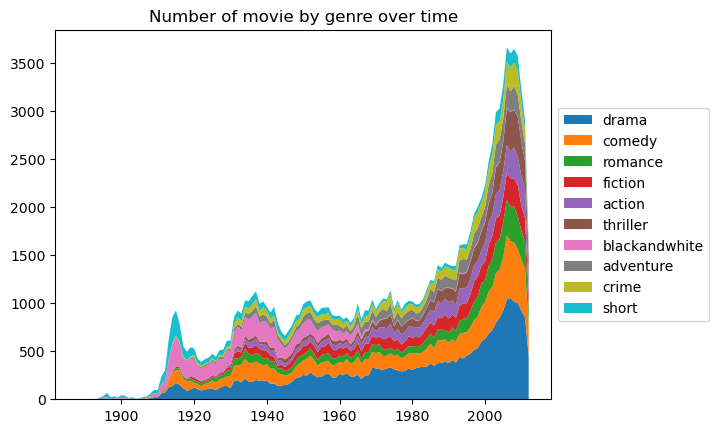

<AxesSubplot:title={'center':'Number of movie by genre over time'}>

In [17]:
def plot_stack_plot(df, labels, xaxis, title): 
    """
    Plots a stackplot.
    """
    vstack = []
    for genre in labels: 
        vstack.append(list(df[genre]))

    vstack = np.vstack(vstack)
    fig, ax = plt.subplots()
    ax.stackplot(xaxis, vstack, labels=labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return ax

# Prepare new dataframe for plotting 
stackplot_df = movie_df[['release_date', 'genre_divided']].copy()
top_ten_genres = top_ten_list.index
for genre in top_ten_genres: 
    stackplot_df[genre] = 0

for genre in top_ten_genres:
    stackplot_df[genre] = stackplot_df['genre_divided'].apply(lambda x: 1 if genre in x else 0)

grouped_by = stackplot_df.groupby(by='release_date').sum().reset_index()
years = list(range(1888, 2013, 1))
plot_stack_plot(
    grouped_by, 
    top_ten_genres, 
    years, 
    'Number of movie by genre over time'
)

#### Normalized genres 
We realize that the above result might be affected by the number of labels it has. For example, a movie as ["comedy", "romance", and "blackandwhite" ] would contribute more to the graph by having each of those genres added. Therefore, we normalized the result by weighing each genre so they contribute equally. For instance, comedy, romance, and blankandwhite would each contribute 0.33 to the overall count.

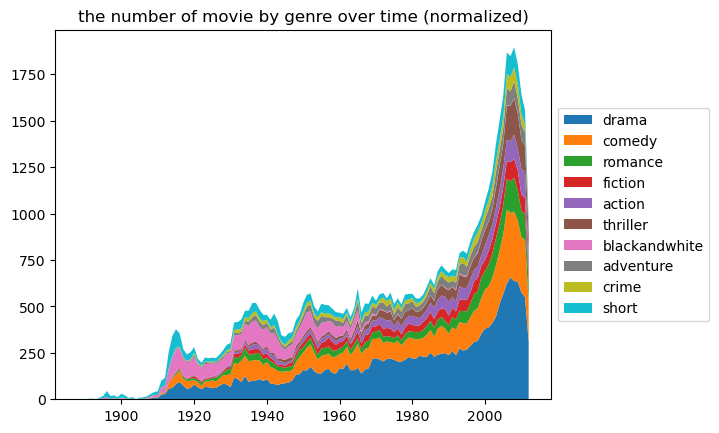

<AxesSubplot:title={'center':'the number of movie by genre over time (normalized)'}>

In [18]:
normalized_stack_df = stackplot_df.copy()
normalized_stack_df["sum"] = normalized_stack_df.iloc[:, 2:12].sum(axis=1)
for genre in top_ten_genres:
    normalized_stack_df[genre] = normalized_stack_df[genre] / normalized_stack_df['sum']

normalized_group_by = normalized_stack_df.groupby(by='release_date').sum().reset_index()
plot_stack_plot(normalized_group_by, top_ten_genres, years, "the number of movie by genre over time (normalized)")

#### Genre change in terms of percentage 
Let's look at how the popularity of genres have changed over time. 

,release_date,drama,comedy,romance,fiction,action,thriller,blackandwhite,adventure,crime,short,sum
120,2008,0.278082,0.168767,0.104384,0.078630,0.088219,0.107397,0.000548,0.068219,0.065753,0.040000,3650
121,2009,0.281477,0.155568,0.095971,0.091214,0.083380,0.115557,0.000839,0.063514,0.071349,0.041130,3574
122,2010,0.286646,0.165217,0.093478,0.079503,0.097205,0.108696,0.000000,0.066460,0.060248,0.042547,3220
123,2011,0.294178,0.174991,0.097485,0.083707,0.106786,0.097830,0.000000,0.062005,0.050637,0.032380,2903
124,2012,0.277675,0.200371,0.114409,0.072975,0.116883,0.110699,0.001237,0.042672,0.039579,0.023500,1617


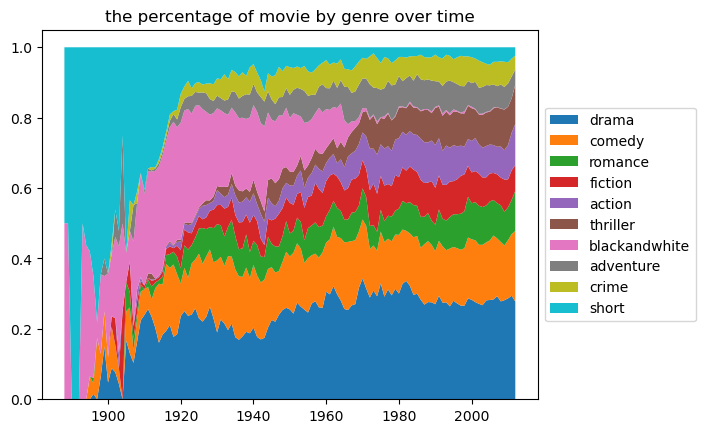

<AxesSubplot:title={'center':'the percentage of movie by genre over time'}>

In [19]:
percentage_df = grouped_by.copy()
percentage_df['sum'] = percentage_df.iloc[:, 1:11].sum(axis=1)
for genre in top_ten_genres:
    percentage_df[genre] = percentage_df[genre]/percentage_df['sum']

display(percentage_df.tail(5))
plot_stack_plot(percentage_df, top_ten_genres, years, "the percentage of movie by genre over time")

### Data Analysis Part 1 conclusion
* We can see that there is a sharp increase in the number of movies made since the 2000s
* Black and white movies almost disappeared completely after 1970s
* Short movies are less frequent 

## Data Analysis Part 2: Statistical tests, Genre vs Historical Events

In [20]:
from scipy import stats

def movies_by_genre_over_time(df, genre):
    """
    Get the number of movies with a particular genre for every year and the fraction
    number movies of genre / total number of movies (for a given year)

    returns: DataFrame (cols = [release_date, genre_count, total_count, fraction])
    """
    mask = df['genres'].apply(lambda x: genre in x)
    genre_df = df[mask]
    genre_df = genre_df.groupby(by='release_date').count()[['name']]
    genre_df = genre_df.rename(columns={'name': f'{genre}_count'})
    df2 = df.groupby(by='release_date').count()[['name']]
    genre_df['total_count'] = df2['name']
    genre_df['fraction'] = genre_df[f'{genre}_count'] / genre_df['total_count']
    return genre_df

def get_idx_from_date(df, event_year):
    """
    Returns the index for a year in the df received from the movies_by_genre_over_time-function
    """
    idx = 0
    for year in df.index.values:
        if year == event_year:
            return idx
        idx += 1
    return idx

def run_ttest_on_event(event, df : pd.DataFrame):
    """
    Runs a t-test comparing the fraction of movies made by genre BEFORE vs AFTER the event occured

    return: scipy.stats.ttest
    """
    date = event['date']
    if len(date) == 9:
        # The event was a range of years, e.g. from 1939-1945
        start_date = date.split('-')[0]
        end_date = date.split('-')[1]

        start_idx = get_idx_from_date(df, start_date)
        end_idx = get_idx_from_date(df, end_date)
        before_event = df.iloc[:start_idx]
        after_event = df.iloc[end_idx:]
    else:
        # The event was a single year 
        idx = get_idx_from_date(df, date)
        before_event = df.iloc[:idx]
        after_event = df.iloc[idx:]
    return stats.ttest_ind(before_event['fraction'], after_event['fraction'])

In [21]:
# Example usage of these functions. As we can see, there is a significant difference in the occurrences of "War film" after the World War II.
war_movie_df = movies_by_genre_over_time(movie_df, 'War film')
event = {'name': 'World War II', 'date': '1939-1945', 'link': 'https://en.wikipedia.org/wiki/World_War_II'}
run_ttest_on_event(event, war_movie_df)

Ttest_indResult(statistic=nan, pvalue=nan)

Now, lets run the analysis on all events (in AnnotatedListOfEvents.json) against all genres 

In [22]:
def convert_list_to_string(list_):
    string = ""
    for idx, e in enumerate(list_):
        if idx == len(list_)-1:
            string += str(e)
        else:
            string += str(e) + ", "
    return string

def get_all_unique_genres(df: pd.DataFrame) -> list:
    """
    returns all unique genres in the df
    """
    mydf = df.copy()
    mydf['genres'] = mydf['genres'].apply(lambda x: convert_list_to_string(x))
    genre_list = mydf['genres'].unique()
    genres = []
    for genre in genre_list:
        genre_list = genre.split(', ')
        for e in genre_list:
            genres.append(e)
    genres = list(set(genres))
    return genres

def filter_significant_tests(list_of_tests, alpha):
    """
    Returns a list of tests that is significant on significance level alpha
    """
    return [x for x in list_of_tests if x[2][1] < alpha]

# Run analysis 
genres = get_all_unique_genres(movie_df)
ttest_list = []
genre_dfs = []
for genre in genres:
    genre_dfs.append(movies_by_genre_over_time(movie_df, genre))
for event in event_data:
    for genre_df in genre_dfs:
        ttest = run_ttest_on_event(event, genre_df)
        ttest_list.append([event, str(genre_df.columns[0]).replace('_count', ''), ttest])

In [23]:
# Significance level alpha = 0.005
significant_ttests = filter_significant_tests(ttest_list, 0.005)
print("Number of tests done (Event vs Production of Genre Combinations):", len(ttest_list))
print("Number of significant (alpha = 0.005) increases / descreases after event:", len(significant_ttests))

Number of tests done (Event vs Production of Genre Combinations): 9100
Number of significant (alpha = 0.005) increases / descreases after event: 0


In [27]:
# TODO: might want to delete this one 
len(significant_ttests)
# TODO: this is stochastic, ie changing each time we run it, if we give example find one that only appears once eg

IndexError: list index out of range

The cell above indicates that after "President Kennedy Is Assasinated" occured the production of the "Horror"-genre INCREASED, the p-value of this is: p ≈ 1.01e-16

In [ ]:
significant_ttests[10]

[{'name': "Albert Einstein's formulation of special relativity",
  'date': '1905',
  'link': 'Theory_of_relativity'},
 'Short Film',
 Ttest_indResult(statistic=13.853663633189848, pvalue=6.0034808994889e-27)]

The cell above indicates that after "Albert Einstein's formulation of special relativity" occured the production of the "Silent film"-genre DECREASED, the p-value of this is: p ≈ 2.0e-5

### Comments

At the significance level $\alpha$ = 0.005, 1,512 out of 12,376 turned out "significant". But the exampel above suggests that there still are combinations in this set which doesn't make sense. The event of Albert Einstein publishing his work on special relativity propably didn't cause the genre "Silent film" to decrease. We treat the results from the t-tests above as an initial filter. Now we can do further analysis these combinations. The next step of the analysis will be to compare plot summaries of movies to Wikipedia summaries events. By doing this we might be able to see if there actually is any similarity between the historical event and movies that followed it. Example; the plot summaries of the "Silent films" that followed Einstein's discovery probabaly won't have anything to do with special relativity and we can rule them out.

## Data Analysis Part 3: Plot Summaries and Historical Events Similarity

In [ ]:
%pip install gensim
%pip install nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import pathlib
import multiprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 776.8 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.9/293.9 kB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 1.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/gladys/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


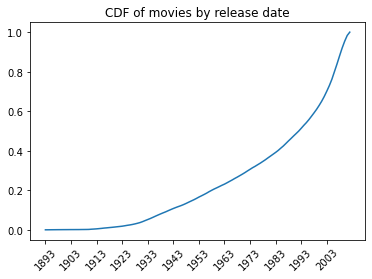

In 1940, 3590 movies had been created, which is more than 9% of the total movies. This should be enough to do analysis, which motivates why we only look at events after 1940.


,release_date,movies_before,movies_before_percentage
47,1940,3590,0.090861


In [ ]:
import string

def parseDocument(doc):
        """
        Parses a string into a format that is more suitable for later NLP applications.

        returns: parsed string
        """
        # TODO: use insights from lectures about handling text and see if we can improve this pipeline
        return word_tokenize(
                doc
                .lower()
                # Remove certain special characters
                .replace('\n', '')
                .replace('\r', '')
                # Remove punctuation and special characters
                .translate(str.maketrans('', '', string.punctuation))
        )

def plot_cdf(df : pd.DataFrame):
        cdf = df.copy()
        cdf = df.groupby('release_date').count().sort_values('release_date').reset_index()
        cdf['movies_before'] = cdf['name'].cumsum()
        cdf['movies_before_percentage'] = cdf['movies_before'] / df.shape[0]
        cdf = cdf[['release_date', 'movies_before', 'movies_before_percentage']]
        cdf_1940 = cdf[cdf['release_date'] == 1940]
        # TODO: make graph prettier (do last thing so we synch all graph apperances) 
        plt.plot(cdf['release_date'], cdf['movies_before_percentage'])
        plt.xticks(np.arange(cdf['release_date'].min(), cdf['release_date'].max(), 10), rotation = 45) 
        plt.title('CDF of movies by release date')
        plt.show()
        print("In 1940, 3590 movies had been created, which is more than 9% of the total movies. This should be enough to do analysis, which motivates why we only look at events after 1940.")
        display(cdf_1940)

# Create new df where we remove all rows with missing plots
plot_removed = data_clean_movies(orig_movie_df)
plot_removed =  plot_removed[plot_removed['plot'].notna()]

# Analyze the distributions of movies with plots 
plot_cdf(plot_removed)

# First, we tokenize all plot summaries
tokenized_df = plot_removed.copy()
tokenized_summaries = tokenized_df['plot'].values
tokenized_summaries = [TaggedDocument(parseDocument(doc), [idx]) for idx, doc in enumerate(tokenized_summaries)]

In [ ]:
def create_doc2vec_model(documents, force_train_new = False):
    """
    Loads existing model from disk if available else trains new model.
    Set force_train_new to True to train a new model even if a previous model exists.
    
    returns: trained Doc2Vec model
    """

    fname = str(pathlib.Path().resolve()) + "/doc2vec_model"
    if not force_train_new:
        # Try to load, if it succeeds then previous model existed so return that one
        try:
            return Doc2Vec.load(fname)
        except:
            print("Failed to load existing model")

    # Train model
    print("Start training of Doc2Vec model...")
    model = Doc2Vec(
        documents, 
        window=2, 
        min_count=1, 
        workers=multiprocessing.cpu_count(), 
        epochs = 100
    )
    
    # Persist the model
    print(f"Finished training Doc2Vec, saving it to file {fname}")
    model.save(fname)
    return model

# Train the doc2vec model
model = create_doc2vec_model(tokenized_summaries, force_train_new=False)

Start training of Doc2Vec model...
Finished training Doc2Vec, saving it to file /Users/joelrudsberg/Desktop/EPFL/Applied Data Analysis/ada-2022-project-adawizardry/doc2vec_model


In [ ]:
# As a proof-of-concept we run the word2vec model using the event of Apollo 13 (the text is copied from Wikipedia).

apollo_wiki = """Apollo 13 (April 11–17, 1970) was the seventh crewed mission in the Apollo space program and the third meant to land on the Moon. The craft was launched from Kennedy Space Center on April 11, 1970, but the lunar landing was aborted after an oxygen tank in the service module (SM) failed two days into the mission. The crew instead looped around the Moon and returned safely to Earth on April 17. The mission was commanded by Jim Lovell, with Jack Swigert as command module (CM) pilot and Fred Haise as Lunar Module (LM) pilot. Swigert was a late replacement for Ken Mattingly, who was grounded after exposure to rubella.

A routine stir of an oxygen tank ignited damaged wire insulation inside it, causing an explosion that vented the contents of both of the SM's oxygen tanks to space. Without oxygen, needed for breathing and for generating electric power, the SM's propulsion and life support systems could not operate. The CM's systems had to be shut down to conserve its remaining resources for reentry, forcing the crew to transfer to the LM as a lifeboat. With the lunar landing canceled, mission controllers worked to bring the crew home alive.

Although the LM was designed to support two men on the lunar surface for two days, Mission Control in Houston improvised new procedures so it could support three men for four days. The crew experienced great hardship, caused by limited power, a chilly and wet cabin and a shortage of potable water. There was a critical need to adapt the CM's cartridges for the carbon dioxide scrubber system to work in the LM; the crew and mission controllers were successful in improvising a solution. The astronauts' peril briefly renewed public interest in the Apollo program; tens of millions watched the splashdown in the South Pacific Ocean on television.

An investigative review board found fault with preflight testing of the oxygen tank and Teflon being placed inside it. The board recommended changes, including minimizing the use of potentially combustible items inside the tank; this was done for Apollo 14. The story of Apollo 13 has been dramatized several times, most notably in the 1995 film Apollo 13 – based on Lost Moon, the 1994 memoir co-authored by Lovell – and an episode of the 1998 miniseries From the Earth to the Moon."""

# Use the model to create a vectorized representation of the event text
test_doc = parseDocument(apollo_wiki)
test_vector = model.infer_vector(test_doc)

# Compare the event vector against all vectors of the movie summaries and extract the most similar ones
top_similar = model.dv.most_similar(positive=[test_vector],topn=1000)

# Create a df from this and merge with movie_df so we can get some movie information
top_similar_df = pd.DataFrame(top_similar, columns=["id", "similarity"]).set_index("id")
plot_removed = plot_removed.reset_index(drop=True)
top_similar_df = pd.merge(top_similar_df, plot_removed, left_index=True, right_index=True)[["name", "similarity", "release_date", "plot"]]
top_similar_df

,name,similarity,release_date,plot
39059,Apollo 13,0.680685,1995,"On July 20, 1969, veteran astronaut Jim Lovell..."
38440,The Dream is Alive,0.649839,1985,The movie includes scenes from numerous shuttl...
985,K-19: The Widowmaker,0.630763,2002,"In 1961, the Soviet Union launches its first b..."
25626,Rocket Man,0.614541,1997,NASA is training for the first manned mission ...
35627,Five Star Stories,0.586584,1989,The Five Star Stories takes its name from the ...
...,...,...,...,...
34802,I'll Never Forget What's 'Isname,0.364134,1967,The film deals with creativity and commerciali...
5248,Project Viper,0.364075,2002,The space shuttle Olympus is on a routine miss...
3525,Fat Man and Little Boy,0.364025,1989,"In September 1943, U.S. Army Corps of Engineer..."
18832,Don't Look Now... We're Being Shot At!,0.364010,1966,"Summer 1941. Over Nazi-occupied France, a Roya..."


### Comments
As expected, the top 10 movies are similar in terms of plot to the Apollo 13 event. With this proof-of-concept we have proved that it's possible to match movie plots to wikipedia summaries. We now have a great foundation to further develop our work, as outlined in the READ.ME.

#### Q2/
##### Does historical events affect the type of movies produced afterwards?
1. Do similarity score for all historical events and for each
2. Extract top 1000 most similar movies and 
3. do t-test for all categories only using these films as data



In [ ]:
%pip install wikipedia-api
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')


# Use the model to create a vectorized representation of the event text

# Compare the event vector against all vectors of the movie summaries and extract the top 10 most similar ones

# Create a df from this and merge with movie_df so we can get some movie information
plot_removed = plot_removed.reset_index(drop=True)
similarity_df = pd.DataFrame(columns=['name', 'similarity', 'release_date', 'event', "genres"])

# To get data from event, simply call wikipedia.summary with the title of the page 
subjects = [subject['link'] for subject in event_data]
for subject in subjects:
    summary = wiki_wiki.page(subject).summary
    # Use the model to create a vectorized representation of the event text
    test_doc = parseDocument(summary)
    test_vector = model.infer_vector(test_doc)

    # Compare the event vector against all vectors of the movie summaries and extract the top 10 most similar ones
    top_similar = model.dv.most_similar(positive=[test_vector],topn=1000)
    # Create a df from this and merge with movie_df so we can get some movie information
    top_similar_df = pd.DataFrame(top_similar, columns=["id", "similarity"]).set_index("id")
    top_similar_df['event'] = subject
    top_similar_df = pd.merge(top_similar_df, plot_removed, left_index=True, right_index=True)[["name", "similarity", "release_date", "event", "genres"]]
    pd_object = [top_similar_df, similarity_df]
    similarity_df = pd.concat(pd_object)

similarity_df  

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13476 sha256=a3db8f44625cd273e32f99e9ee3d338819b1f94b33d5080dbcfc26a68ed9916c
  Stored in directory: /Users/gladys/Library/Caches/pip/wheels/c7/cf/1a/c300428dd51654cdadc921abdff75acaa7cc80b7151a2f0695
Successfully built wikipedia-api
Note: you may need to restart the kernel to use updated packages.


,name,similarity,release_date,event,genres
42108,The Deluge,0.601123,1974,Negotiations_to_end_apartheid_in_South_Africa,[War film]
24797,The Revolution Will Not Be Televised,0.582563,2003,Negotiations_to_end_apartheid_in_South_Africa,"[Culture Society, Documentary, Indie, Journal..."
24729,The Founding of a Republic,0.580441,2009,Negotiations_to_end_apartheid_in_South_Africa,"[Chinese Movies, Drama, War film, World cinema]"
26272,"I Remember Everything, Richard",0.571152,1966,Negotiations_to_end_apartheid_in_South_Africa,"[Action, War film]"
7405,The Founding of a Party,0.567530,2011,Negotiations_to_end_apartheid_in_South_Africa,"[Drama, Historical fiction]"
...,...,...,...,...,...
9903,Guns,0.413098,1990,Second_Boer_War,"[Action, Drama, Sexploitation, Thriller]"
22787,For the Cause,0.413008,2000,Second_Boer_War,"[Drama, Science Fiction]"
12545,"El Ejido, la loi du profit",0.412993,2006,Second_Boer_War,[Documentary]
33684,The Sorrow and the Pity,0.412962,1971,Second_Boer_War,"[Documentary, History, War film]"


In [ ]:
def extract_event_dates(events):
        dates = {}
        for event in events:
                dates[event['link']] = event['date']
        return dates

dates = extract_event_dates(event_data)        

In [ ]:
similarity_df = similarity_df[similarity_df['release_date'] != 'nan']
similarity_df['release_date'] = similarity_df['release_date'].apply(lambda x : int(x))
def get_df_before_after_date(df, date_string):
        if '-' in date_string:
                date_interval = date_string.split("-")
                date_start = date_interval[0]
                date_end = date_interval[1]
                events_before = df[df["release_date"] < int(date_start)]
                events_after = df[df["release_date"] > int(date_end)]
        else:
                events_before = df[df["release_date"] < int(date_string)]
                events_after = df[df["release_date"] > int(date_string)]
        return (events_before, events_after)

def get_fractions():
        for event in similarity_df['event'].unique():
                event_df = similarity_df[similarity_df["event"] == event]
                before_date, after_date = get_df_before_after_date(event_df, dates[event])

                #return fraction of movies before and after event
                before_date_length = before_date.size
                after_date_length = after_date.size
                after_date_frac = after_date_length / (after_date_length + before_date_length)
                before_date_frac = before_date_length / (after_date_length + before_date_length)

def get_avg_sim_score():
        


                




               


IndentationError: expected an indented block (3821638575.py, line 35)

In [ ]:
for event in similarity_df['event'].unique():
        print(event) 

Negotiations_to_end_apartheid_in_South_Africa
Nelson_Mandela
Fall_of_the_Berlin_Wall
Stanislav_Petrov
Falklands_War
Attempted_assassination_of_Ronald_Reagan#:~:text=On%20March%2030%2C%201981%2C%20President,engagement%20at%20the%20Washington%20Hilton.
Iranian_Revolution#:~:text=Iranian%20people%20voted%20in%20a,it%20created%20throughout%20the%20world.
Apollo_13
Apollo_11
Death_and_state_funeral_of_Winston_Churchill
Civil_Rights_Act_of_1964
Assassination_of_John_F._Kennedy
Berlin_Wall
Vietnam_War
Great_Leap_Forward
Sputnik_2
Hungarian_Revolution_of_1956
Warsaw_Pact
Brown_v._Board_of_Education
Korean_War
Marshall_Plan
Cold_War
Truman_Doctrine
Atomic_bombings_of_Hiroshima_and_Nagasaki
Attack_on_Pearl_Harbor
Adolf_Hitler%27s_rise_to_power
League_of_Nations
Russian_Revolution
Sinking_of_the_RMS_Lusitania
World_War_I
Titanic
Wright_brothers
Theory_of_relativity
Second_Boer_War
